<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

Recurrent neural networks, or RNNs, are great for sequential data. The MNIST image data we’ve been using is not sequential, because there’s no order to the images.

Sequential data, on the other hand, is inherently ordered.

Classic examples are daily temperatures, the daily price of a stock, and the hourly height of a tide. There’s also data that’s ordered, but not in time, such as children lined up by height, shelved library books, and the colors of the rainbow.

In all of these phenomena, we want to use the information in the
sequence of inputs to help us produce new output.

In RNN terminology, we still have a dataset made of samples, where each sample contains multiple features. But now each feature contains multiple values, called time steps. Recall that we can also think of “time steps” as “series of measurements for a given feature.”


## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


## Generating Sequence Data

There are lots of sequential datasets available, but some of them are complicated or hard to draw. So let’s make our own simple dataset that we can easily draw and interpret.

Our little curve-building routine takes three other arguments. The first is an integer called number_of_steps which tells it how many points to generate. 

The second is a float called d_theta that tells the routine the spacing of the samples (the name comes from thinking of the sine wave as based on an angle, which is often written with the lower-case Greek letter θ (theta). 

Finally, skip_steps is an integer that provides an offset to the starting point, so we don’t always begin at 0.

This is useful for creating the test data, which can start far to the right of the training data.

In [0]:
def sum_of_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
  '''
  Add together multiple sine waves and return a list of values that is
  number_of_steps long. d_theta is the step (in radians) between samples.
  skip_steps determines the start of the sequence. The lists freqs, amps,
  and phases should all the same length (but we don't check!)
  '''

  values = []
  for step_num in range(number_of_steps):
    angle = d_theta * (step_num + skip_steps)
    sum = 0
    for wave in range(len(freqs)):
      y = amps[wave] * math.sin(freqs[wave] * (phases[wave] + angle))
      sum += y
    values.append(sum)
  return np.array(values)

Data set 0 is a gentle sum of two waves. We made one wave twice the speed of the other by setting freqs to (1,2), the second wave twice as high as the first by setting amps to (1,2), and started both waves at 0 by setting phases to (0,0), Our training data came from using 200 steps (number_of_steps = 200), a step of about 0.057 radians (d_theta = 0.057), and no offset (skip_steps = 0).

The training set is 200 samples long, starting at 0. The test set is another 200 steps, starting far to the right of the training set.

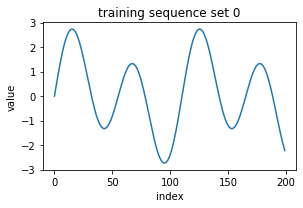

In [3]:
train_sequence_1 = sum_of_sines(200, 0.057, 0, [1, 2], [1, 2], [0, 0])

plt.figure(figsize=(8,3))
        
plt.subplot(1, 2, 1)
plt.plot(train_sequence_1)
plt.title('training sequence set 0')
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()

plt.show()

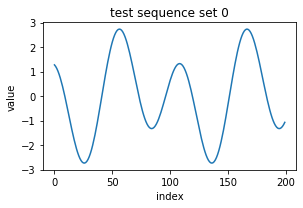

In [4]:
test_sequence_1 = sum_of_sines(200, 0.057, 400, [1, 2], [1, 2], [0, 0])

plt.figure(figsize=(8,3))
        
plt.subplot(1, 2, 1)
plt.plot(test_sequence_1)
plt.title('test sequence set 0')
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()

plt.show()

Data set 1 is a harder challenge that uses 4 waves. For this set, we set freqs to (1.1, 1.7, 3.1, 7), amps to (1, 2, 2, 3), and we again left all the phases at 0, so phases is (0,0,0,0).

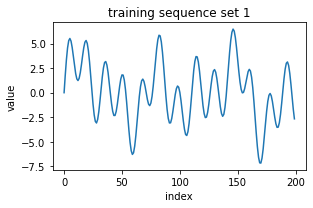

In [5]:
train_sequence_2 = sum_of_sines(200, 0.057, 0, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])

plt.figure(figsize=(8,3))
        
plt.subplot(1, 2, 1)
plt.plot(train_sequence_2)
plt.title('training sequence set 1')
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()

plt.show()

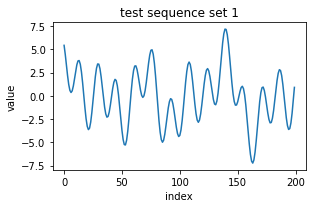

In [6]:
test_sequence_2 = sum_of_sines(200, 0.057, 400, [1.1, 1.7, 3.1, 7], [1, 2, 2, 3], [0, 0, 0, 0])

plt.figure(figsize=(8,3))
        
plt.subplot(1, 2, 1)
plt.plot(test_sequence_2)
plt.title('test sequence set 1')
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()

plt.show()

## RNN Data Preparation

The mechanics for preparing data for RNNs in Keras are a little more complicated than what we’ve been working with so far, because we have to carry out a couple of reshaping steps in order to use all the library routines we want. We also need to extract our little windowed sublists, which we have to do ourselves since there aren’t any library routines to do it for us.

we want to normalize our data to get it into the range [0,1].
The MinMaxScaler from scikit-learn is the perfect tool for the job.

<img src='https://github.com/rahiakela/img-repo/blob/master/min-max-scaler.png?raw=1' width='800'/>

The MinMaxScaler, like most feature-wise normalizers,
reads all the values for each feature, finds the minimum and maximum,and re-scales the data to the range [0,1]. Each feature (a column in thisexample) is scaled independently
Our sine wave data has only one feature, with many time steps, and
it’s a 1D list (that is, it’s not a column as
is expecting).
MinMaxScaler
So let’s reshape our data into a column.Our sine wave data has only one feature, with many time steps, and
it’s a 1D list (that is, it’s not a column as
is expecting).
MinMaxScaler
So let’s reshape our data into a column.